# Graph embedding using SkipGram

This is an embedding of the whole graph, 80/20 training and validation split and all sources

kg-covid-19:
version 20201012

Name: ensmallen-graph
Version: 0.4.4

Name: embiggen
Version: 0.6.0

In [1]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')  # identical to 0.4.3 except for addition of some methods like get_edge_id()
assert(get_distribution("embiggen").version == '0.6.0')

In [2]:
import os

exp_name = "80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_updated_holdouts"
s3_path = "s3://kg-hub-public-data/embeddings/20201012/"  # keep trailing slash
base_url = "https://kg-hub.berkeleybop.io/embeddings/20201012/"

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")
pos_neg_data_dir = os.path.join(base_dl_dir, "pos_neg_data_dir")
pos_neg_data_dir = os.path.join(base_dl_dir, "pos_neg_data_dir")
ranked_drug_dir = os.path.join(base_dl_dir, "ranked-drug-lists")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# pos/neg nodes for better pos/neg edge set
pos_node_url = os.path.join(base_url, pos_neg_data_dir, "positive_nodes.tsv")
pos_node_file = os.path.join(pos_neg_data_dir, "positive_nodes.tsv")
neg_node_url = os.path.join(base_url, pos_neg_data_dir, "negative_nodes.tsv")
neg_node_file = os.path.join(pos_neg_data_dir, "negative_nodes.tsv")

# ranked list stuff
mlp_link_pred_outdir = os.path.join(ranked_drug_dir, "mlp_link_pred")
os.makedirs(mlp_link_pred_outdir, exist_ok=True)

# params
seed = 42
train_percentage = 0.8

In [3]:
sars_cov_2_curie = 'NCBITaxon:2697049'
chembl_prefix = 'CHEMBL.COMPOUND'

In [4]:
nodes_of_interest = ['biolink:Drug',
                     'biolink:Drug|biolink:ChemicalSubstance',
                     'biolink:ChemicalSubstance']

In [5]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

### Load the positive and negative nodes

In [6]:
import urllib
import os
import pandas as pd

os.makedirs(pos_neg_data_dir, exist_ok=True)

if not os.path.exists(pos_node_file):
    with urllib.request.urlopen(pos_node_url) as response, \
        open(pos_node_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

if not os.path.exists(neg_node_file):
    with urllib.request.urlopen(neg_node_url) as response, \
        open(neg_node_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
            
positive_nodes = pd.read_csv(pos_node_file, "\t", header=0, comment='#')
negative_nodes = pd.read_csv(neg_node_file, "\t", header=0, comment='#')

## Loading the graphs
We load the kg-covid-19 graph from the repository as an undirected graph.

In [7]:
# get the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

#### only need to do this once, b/c we'll load the sorted.tsv from now on once it is made below

In [8]:
import pandas as pd
import os

new_edge_file = os.path.join(graph_data_dir, 'edges_with_holdout_column.tsv')

if not os.path.exists(new_edge_file): 
    edges = pd.read_csv(
        graph_data_dir + "/merged-kg_edges.tsv",
        sep="\t",
        usecols=[1,3],
        dtype={'subject': str, 'object': str}
    )
    
    pos_node_curies_set = set(positive_nodes.curie)

    chembl_to_sars_cov_2_edges = (
        (edges.subject.str.contains(chembl_prefix) & (edges.object.isin(pos_node_curies_set))) | 
        (edges.object.str.contains(chembl_prefix) & (edges.subject.isin(pos_node_curies_set)))
    )

    edges['holdout_edge_label'] = [
        'chembl_to_sars_cov_2' if value else 'normal'
        for value in chembl_to_sars_cov_2_edges]


    edges.to_csv(new_edge_file, sep="\t", index=False)

In [9]:
from ensmallen_graph import EnsmallenGraph
graph = EnsmallenGraph.from_unsorted_csv(
    name="kg-covid-19",
    edge_path = new_edge_file,
    sources_column="subject",
    destinations_column="object",
    edge_types_column='holdout_edge_label',
    directed=False,
    node_path = graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

In [10]:
graph

The undirected graph kg-covid-19 has 447766 nodes with 42 different node types:  the 5 most common are biolink:Publication (nodes number 129930), biolink:OntologyClass (nodes number 108266), biolink:Drug (nodes number 32120), biolink:ChemicalSubstance (nodes number 27157) and biolink:Disease (nodes number 24236), of which 8396 are singletons, and 15611957 unweighted edges with 2 different edge types: normal and chembl_to_sars_cov_2, of which 480 are self-loops. The graph is quite sparse as it has a density of 0.00016 and has 9107 connected components, where the component with most nodes has 435728 nodes and the component with the least nodes has 1 nodes. The graph median node degree is 4, the mean node degree is 69.73 and the node degree mode is 1. The top 5 most central nodes are MESH:D014780 (degree 90378), MESH:D006801 (degree 78249), WD:Q30 (degree 65223), MESH:D014777 (degree 54155) and MESH:D017934 (degree 45196).

In [11]:
reduced_graph = graph.remove_components(edge_types=['chembl_to_sars_cov_2'])
reduced_graph = reduced_graph.remove(singletons=True)

In [71]:
reduced_graph

The undirected graph kg-covid-19 has 435728 nodes with 40 different node types:  the 5 most common are biolink:Publication (nodes number 129492), biolink:OntologyClass (nodes number 104951), biolink:Drug (nodes number 32016), biolink:ChemicalSubstance (nodes number 27152) and biolink:Disease (nodes number 22281) and 15608444 unweighted edges with 2 different edge types: normal and chembl_to_sars_cov_2, of which 314 are self-loops. The graph is quite sparse as it has a density of 0.00016 and is connected, as it has a single component. The graph median node degree is 4, the mean node degree is 71.64 and the node degree mode is 1. The top 5 most central nodes are MESH:D014780 (degree 90378), MESH:D006801 (degree 78249), WD:Q30 (degree 65223), MESH:D014777 (degree 54155) and MESH:D017934 (degree 45196).

## Creating the SkipGram model
We are going to setup the model to use, if available, multiple GPUs.

In [12]:
from cache_decorator import Cache
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.optimizers import Nadam
from embiggen import SkipGram
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from embiggen import Node2VecSequence


@Cache(
    cache_path="{cache_dir}/SkipGram/{_hash}_{holdout_idx}.csv.gz",
    cache_dir=embedding_data_dir,
    args_to_ignore=['train_graph']
)
def compute_skipgram_embedding(
    train_graph: EnsmallenGraph,
    holdout_idx: int,
    walk_length: int = 100,
    batch_size: int = 2**9,
    iterations: int = 20,
    return_weight: float = 1.0,
    explore_weight: float = 1.0,
    embedding_size: int = 100,
    change_edge_type_weight: float = 1.0,
    window_size: int = 4,
    negative_samples: int = 7,
    patience: int = 6,
    delta: float = 0.1,
    epochs: int = 500
):
    """Return dataframe with node embedding obtained with SkipGram for train_graph
    
    Given a graph, learn embeddings and return dataframe with node embeddings
    
    Parameters
    -----
    train_graph: EnsmallenGraph
    holdout_idx: int, 
        an int to identify the holdout
    walk_length: int = 100,
        how many nodes for each walk
    batch_size: int = 2**9,
        how many walks for each batch
    iterations: int = 20,
        how many walks per node
    return_weight: float = 1.0,
        node2vec param, equal to 1/p
    explore_weight: float = 1.0,
        node2vec param, equal to 1/q
    embedding_size: int = 100,
        dimensions for embedding
    window_size: int = 4,
        SkipGram window size
    negative_samples: int = 7,
        how many negative samples that NCE function needs to sample
    patience: int = 6,
        how many epochs to wait for loss fxn to improve by [delta]
    delta: float = 0.1
        change in loss fxn to be considered an improvement
        
    Return:
    -------
    pd.DataFrame containing an embedding for each node in train_graph
    """
    training_sequence = Node2VecSequence(
        train_graph,
        walk_length=walk_length,
        batch_size=batch_size,
        iterations=iterations,
        window_size=window_size,
        return_weight=return_weight,
        explore_weight=explore_weight,
        change_edge_type_weight=change_edge_type_weight,
        support_mirror_strategy=True
    )

    strategy = MirroredStrategy()
    with strategy.scope():
        model = SkipGram(
            vocabulary_size=train_graph.get_nodes_number(),
            embedding_size=embedding_size,
            window_size=window_size,
            negative_samples=negative_samples,
        )

    history = model.fit(
        training_sequence,
        steps_per_epoch=training_sequence.steps_per_epoch,
        epochs=epochs,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=delta,
                patience=patience,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor="loss",
                patience=patience//2,
                min_delta=delta
            )
        ]
    )
    return model.get_embedding_dataframe(train_graph.get_node_names())

# Link prediction models

In [14]:
from typing import List, Dict, Tuple
import numpy as np

def create_ranking(edges: List[Tuple[str, str]], predictions: np.ndarray) -> Dict:
    """Return ranking of edges and predictions.

    Parameters
    ---------------------
    edges: List[Tuple[str, str]],
        Edges to be predicted.
    predictions: np.ndarray,
        Predictions of the model.

    Returns
    ---------------------
    Dictionary of the ranking.
    """
    return dict(zip(edges, predictions))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Recall, Precision
from typing import Dict

@Cache(    
    cache_path="{cache_dir}/model_predictions/mlp/{embedding_model}/{holdout}_{_hash}.pkl.gz",
    cache_dir=embedding_data_dir,
    args_to_ignore=["train_X", "train_y", "test_X", "graph_test_X", "edges", "batch_size"]
)
def mlp(
    holdout: int,
    edge_embedding_method: str,    
    embedding_model: str,
    train_X: np.ndarray,
    train_y: np.ndarray,
    test_X: np.ndarray,
    graph_test_X: np.ndarray,
    edges: List[Tuple[str, str]],
    epochs: int = 500,
    batch_size: int = 256,
    patience: int = 10,
    min_delta: float = 0.000001,
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """Return random forest predictions on the given values.

    Parameters
    ----------------------
    holdout: int,
        Number of the holdout.
    embedding_model: str,
        Name of the embedding model.
    train_X: np.ndarray,
        Data to use as input for training process.
    train_y: np.ndarray,
        Data to use as output for the training process.
    test_X: np.ndarray,
        Data to use as input for the testing process.
    graph_test_X: np.ndarray,
        Data to use for the ranking of the edges.
    edges: List[Tuple[str, str]],
        Edge names to be ranked.

    Returns
    ----------------------
    Tuple with training and test predictions.
    """
    model = Sequential([
        Input(train_X.shape[1:]),
        Dense(64, activation="relu"),
        Dense(32, activation="relu",
              activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.3),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=[
            AUC(curve="PR", name="auprc"),
            AUC(curve="ROC", name="auroc"),
            Recall(name="Recall"),
            Precision(name="Precision"),            
            "accuracy"
        ]
    )
    model.fit(
        train_X, train_y,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[
            EarlyStopping("loss", patience=patience, min_delta=min_delta)
        ],
        verbose=False
    )
    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X).flatten()
    return train_pred, test_pred, create_ranking(
        edges, model.predict(graph_test_X).flatten()
    )

In [16]:
"""Submodule offering method to execute cached random forest."""
from typing import Tuple, Dict, List
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count
from cache_decorator import Cache

@Cache(    
    cache_path="{cache_dir}/model_predictions/random_forest/{embedding_model}/{holdout}_{_hash}.pkl.gz",
    cache_dir=embedding_data_dir,
    args_to_ignore=["train_X", "train_y", "test_X", "graph_test_X", "edges"]
)
def random_forest(
    holdout: int,
    edge_embedding_method: str,
    embedding_model: str,
    train_X: np.ndarray,
    train_y: np.ndarray,
    test_X: np.ndarray,
    graph_test_X: np.ndarray,
    edges: List[Tuple[str, str]]
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """Return random forest predictions on the given values.

    Parameters
    ----------------------
    holdout: int,
        Number of the holdout.
    edge_embedding_method: str,
        Name of the edge embedding model.
    embedding_model: str,
        Name of the embedding model.
    train_X: np.ndarray,
        Data to use as input for training process.
    train_y: np.ndarray,
        Data to use as output for the training process.
    test_X: np.ndarray,
        Data to use as input for the testing process.
    graph_test_X: np.ndarray,
        Data to use for the ranking of the edges.
    edges: List[Tuple[str, str]],
        Edge names to be ranked.

    Returns
    ----------------------
    Tuple with training and test predictions.
    """
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        n_jobs=cpu_count(),
        class_weight="balanced_subsample",
        max_samples=0.5
    )
    model.fit(train_X, train_y)
    train_pred = model.predict_proba(train_X)[:, 1]
    test_pred = model.predict_proba(test_X)[:, 1]
    return train_pred, test_pred, create_ranking(edges, model.predict_proba(graph_test_X)[:, 1])

In [17]:
from typing import Tuple, Dict, List
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from cache_decorator import Cache

@Cache(
    cache_path="{cache_dir}/model_predictions/decision_tree/{embedding_model}/{holdout}_{_hash}.pkl.gz",    
    cache_dir=embedding_data_dir,    
    args_to_ignore=["train_X", "train_y", "test_X", "graph_test_X", "edges"]
)
def decision_tree(
    holdout: int,
    edge_embedding_method: str,    
    embedding_model: str,
    train_X: np.ndarray,
    train_y: np.ndarray,
    test_X: np.ndarray,
    graph_test_X: np.ndarray,
    edges: List[Tuple[str, str]]
) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """Return decision tree predictions on the given values.

    Parameters
    ----------------------
    holdout: int,
        Number of the holdout.
    edge_embedding_method: str,
        Name of the edge embedding model.
    embedding_model: str,
        Name of the embedding model.
    train_X: np.ndarray,
        Data to use as input for training process.
    train_y: np.ndarray,
        Data to use as output for the training process.
    test_X: np.ndarray,
        Data to use as input for the testing process.
    graph_test_X: np.ndarray,
        Data to use for the ranking of the edges.
    edges: List[Tuple[str, str]],
        Edge names to be ranked.

    Returns
    ----------------------
    Tuple with training and test predictions.
    """
    model = DecisionTreeClassifier(max_depth=10, class_weight="balanced")
    model.fit(train_X, train_y)
    train_pred = model.predict_proba(train_X)[:, 1]
    test_pred = model.predict_proba(test_X)[:, 1]
    return train_pred, test_pred, create_ranking(edges, model.predict_proba(graph_test_X)[:, 1])


In [18]:
from typing import Tuple, Dict, List
import numpy as np
from sklearn.linear_model import LogisticRegression
from cache_decorator import Cache

@Cache(
    cache_path="{cache_dir}/model_predictions/logistic_regression/{embedding_model}/{holdout}_{_hash}.pkl.gz",    
    cache_dir=embedding_data_dir,
    args_to_ignore=["train_X", "train_y", "test_X", "graph_test_X", "edges"]
)
def logistic_regression(
    holdout: int,
    edge_embedding_method: str,    
    embedding_model: str,
    train_X: np.ndarray,
    train_y: np.ndarray,
    test_X: np.ndarray,
    graph_test_X: np.ndarray,
    edges: List[Tuple[str, str]]
) -> Tuple[np.ndarray, np.ndarray, LogisticRegression]:
    """Return logistic regression predictions on the given values.

    Parameters
    ----------------------
    holdout: int,
        Number of the holdout.
    edge_embedding_method: str,
        Name of the edge embedding model.
    embedding_model: str,
        Name of the embedding model.
    train_X: np.ndarray,
        Data to use as input for training process.
    train_y: np.ndarray,
        Data to use as output for the training process.
    test_X: np.ndarray,
        Data to use as input for the testing process.
    graph_test_X: np.ndarray,
        Data to use for the ranking of the edges.
    edges: List[Tuple[str, str]],
        Edge names to be ranked.

    Returns
    ----------------------
    Tuple with training and test predictions.
    """
    model = LogisticRegression(class_weight="balanced", max_iter=1000)
    model.fit(train_X, train_y)
    train_pred = model.predict_proba(train_X)[:, 1]
    test_pred = model.predict_proba(test_X)[:, 1]
    return train_pred, test_pred, create_ranking(edges, model.predict_proba(graph_test_X)[:, 1])


In [19]:
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, recall_score, precision_score
from sanitize_ml_labels import sanitize_ml_labels
from typing import Dict
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

def specificity_score(y_true: np.ndarray, y_pred: np.ndarray):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

def get_metrics_report(y_true: np.ndarray, y_pred: np.ndarray)->Dict[str, float]:
    float_metrics = (average_precision_score, roc_auc_score)
    integer_metrics = (accuracy_score, recall_score, precision_score, specificity_score, f1_score)
    integer_y_pred = y_pred.round().astype(int)

    return {
        **{
            sanitize_ml_labels(metric.__name__): metric(y_true, integer_y_pred)
            for metric in integer_metrics
        },
        **{
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        }
    }


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def make_pca_scatter_plot(train_X, train_y, test_X, test_y, edge_method):
    pca = PCA(
        n_components=2,
        random_state=seed
    )
    pca.fit(train_X)
    train_X_2d = pca.transform(train_X)

    test_X_2d = pca.transform(test_X)
    
    plt.title(edge_method)
    plt.scatter(*train_X_2d[train_y==0].T, s=3, alpha=0.8, label="neg train edges")
    plt.scatter(*train_X_2d[train_y==1].T, s=3, alpha=0.8, label="pos train edges")

    plt.scatter(*test_X_2d[test_y==0].T, s=3, alpha=0.8, label="neg test edges")
    plt.scatter(*test_X_2d[test_y==1].T, s=3, alpha=0.8, label="pos test edges")

    plt.legend()
    plt.show()

### Measure performance by making Skipgram embeddings for N different holdouts, train link prediction classifiers, and measure performance N times

In [21]:
chembl_nodes = [
    node
    for node in reduced_graph.filter(edge_types=['chembl_to_sars_cov_2']).remove(singletons=True).get_node_names()
    if node.startswith("CHEMBL.COMPOUND")
]

In [22]:
import numpy as np
neg_bp_edges = np.array(reduced_graph.get_bipartite_edge_names(
    removed_existing_edges=False,
    first_nodes_set=set(chembl_nodes),
    second_nodes_set=set(negative_nodes.curie)
))
num_neg_edges = int(reduced_graph.get_edge_count_by_edge_type_name('chembl_to_sars_cov_2')/2 * 50)
np.random.shuffle(neg_bp_edges)
neg_bp_edges = neg_bp_edges[:num_neg_edges]

In [57]:
# make holdouts
from tqdm.auto import trange, tqdm
from embiggen import EdgeTransformer, GraphTransformer, LinkPredictionTransformer
from sklearn.model_selection import train_test_split

plot = False

link_prediction_models = [
    mlp, 
    logistic_regression,
    random_forest,
    decision_tree
]

rankings = {}
results = []

for holdout in trange(7, desc="computing embeddings"): # TODO: increase holdout to 15-20
    
    pos_training, pos_validation = reduced_graph.connected_holdout(
        train_size=train_percentage, 
        edge_types=['chembl_to_sars_cov_2'],
        random_state=seed + holdout)
    
    # pos_training.enable_fast_walk()
    embedding = compute_skipgram_embedding(pos_training, holdout)
            
    for edge_embedding_method in tqdm(EdgeTransformer.methods,
                                      desc="edge embeddings",
                                      leave=False):
        rankings[edge_embedding_method] = rankings.get(edge_embedding_method, {})

        graph_transformer = GraphTransformer(method=edge_embedding_method)
        graph_transformer.fit(embedding)
        graph_test_X = graph_transformer.transform(pos_validation)

        transformer = LinkPredictionTransformer(method=edge_embedding_method)
        transformer.fit(embedding)
        
        neg_bp_train, neg_bp_test = train_test_split(neg_bp_edges,
                                                     test_size=1-train_percentage,
                                                     random_state=seed + holdout)
        
        train_X, train_y = transformer.transform(
            positive_graph=pos_training.filter(edge_types=['chembl_to_sars_cov_2']), 
            negative_graph=neg_bp_train,
            random_state=seed + holdout
        )
        test_X, test_y = transformer.transform(
            positive_graph=pos_validation.filter(edge_types=['chembl_to_sars_cov_2']),
            negative_graph=neg_bp_test,
            random_state=seed + holdout
        )

        if plot:
            make_pca_scatter_plot(train_X, train_y, test_X, test_y, edge_embedding_method)
            
        for link_prediction_model in tqdm(link_prediction_models, desc="models", leave=False):
            rankings[edge_embedding_method][link_prediction_model.name] = \
                rankings[edge_embedding_method].get(link_prediction_model.name, [])            

            train_pred, test_pred, link_prediction_ranking = link_prediction_model(
                holdout=holdout,
                edge_embedding_method=edge_embedding_method,
                embedding_model='SkipGram',
                train_X=train_X,
                train_y=train_y,
                test_X=test_X,
                graph_test_X=graph_test_X,
                edges=pos_validation.get_edge_names()
            )
            rankings[edge_embedding_method][link_prediction_model.__name__].append(link_prediction_ranking)
            
            for run, true, predictions in (
                ("train", train_y, train_pred),
                ("test", test_y, test_pred)
            ):
                results.append({
                    "run": run,
                    "model": link_prediction_model.__name__,
                    "edge_embedding_method": edge_embedding_method,
                    "holdout_number": holdout,
                    **get_metrics_report(true, predictions)
                })

ValueError: The first argument to `Layer.call` must always be passed.

In [24]:
from barplots import barplots

results_pd = pd.DataFrame(results)


def sort_bars(df:pd.DataFrame)->pd.DataFrame:
    return df.sort_values(["model", "run"], ascending=[True, False])

custom_defaults={
    "Decision Tree": "decision_tree_cached",
    "Logistic Regression": "logistic_regression_cached",
    "Random Forest": "random_forest_cached"
}

figures = barplots(
    results_pd.drop(columns=["holdout_number"]),
    groupby=["edge_embedding_method",  "model", "run"],
    sort_bars=sort_bars,
    subplots=True,
    show_legend=False,
    orientation="horizontal",
    # height=4,
    # bar_width=0.15,
    # space_width=0.1,
    # legend_position="lower right",
    custom_defaults=custom_defaults,
    use_multiprocessing=True,
)

## Do link prediction on reduced_graph

In [18]:
reduced_graph_embedding = compute_skipgram_embedding(reduced_graph, -100)
reduced_graph_embedding.to_csv(os.path.join(embedding_data_dir, "SkipGram", "reduced_graph.csv.gz"),
                               compression="gzip")

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Recall, Precision
from typing import Tuple

def mlp_link_pred(shape: Tuple) -> Sequential:
    """Return random forest predictions on the given values.

    Parameters
    ----------------------
    Lorem ipsum

    Returns
    ----------------------
    MLP model
    """
    model = Sequential([
        Input(shape),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="linear"),
        BatchNormalization(),
        Activation(activation="relu"),
        Dropout(0.2),        
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="linear"),
        BatchNormalization(),
        Activation(activation="relu"),
        Dropout(0.3),        
        Dense(32, activation="relu"),
        Dense(32, activation="relu"),
        Dense(32, activation="linear"),
        BatchNormalization(),
        Activation(activation="relu"), 
        Dropout(0.4),
        Dense(32, activation="relu"),
        Dense(32, activation="relu"),
        Dense(32, activation="linear"),
        BatchNormalization(),
        Activation(activation="relu"),         
        Dropout(0.5),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=[
            AUC(curve="PR", name="auprc"),
            AUC(curve="ROC", name="auroc"),
            Recall(name="Recall"),
            Precision(name="Precision"),            
            "accuracy"
        ]
    )
    return model

In [47]:
from embiggen import LinkPredictionSequence
from tensorflow.distribute import MirroredStrategy

best_edge_method = "average"

link_prediction_seq = LinkPredictionSequence(
    graph=reduced_graph,
    embedding=reduced_graph_embedding,
    method=best_edge_method,
    batches_per_epoch=2**10,
    batch_size=2**12,
    negative_samples=2,
    support_mirror_strategy=True,
    aligned_node_mapping=True,
    seed=seed,
)

strategy = MirroredStrategy()
with strategy.scope():
    mlp = mlp_link_pred(
        shape=(100,)
    )
mlp.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 64)                6464      
_________________________________________________________________
dense_106 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_107 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)                256       
_________________________________________________________________
activation_28 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 64)               

In [48]:
history = mlp.fit(
    link_prediction_seq,
    epochs=1000,
    steps_per_epoch=link_prediction_seq.steps_per_epoch,
    callbacks=[
        EarlyStopping(
            monitor='loss',
            min_delta=0,
            patience=15,
            restore_best_weights=True
        )
    ]
).history

Epoch 1/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2901 - auprc: 0.9035 - auroc: 0.9298 - Recall: 0.8055 - Precision: 0.8514 - accuracy: 0.8882
Epoch 2/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2636 - auprc: 0.9178 - auroc: 0.9372 - Recall: 0.8286 - Precision: 0.8609 - accuracy: 0.8982
Epoch 3/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2597 - auprc: 0.9200 - auroc: 0.9382 - Recall: 0.8313 - Precision: 0.8625 - accuracy: 0.8996
Epoch 4/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2577 - auprc: 0.9213 - auroc: 0.9388 - Recall: 0.8350 - Precision: 0.8617 - accuracy: 0.9003
Epoch 5/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2560 - auprc: 0.9223 - auroc: 0.9394 - Recall: 0.8353 - Precision: 0.8631 - accuracy: 0.9009
Epoch 6/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2552 - auprc: 0.9228 - auroc: 0.9399 - Reca

1024/1024 [==============================] - 19s 19ms/step - loss: 0.2455 - auprc: 0.9294 - auroc: 0.9467 - Recall: 0.8515 - Precision: 0.8625 - accuracy: 0.9052
Epoch 94/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2454 - auprc: 0.9295 - auroc: 0.9467 - Recall: 0.8519 - Precision: 0.8626 - accuracy: 0.9054
Epoch 95/1000
1024/1024 [==============================] - 20s 19ms/step - loss: 0.2454 - auprc: 0.9295 - auroc: 0.9468 - Recall: 0.8516 - Precision: 0.8627 - accuracy: 0.9053
Epoch 96/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2453 - auprc: 0.9295 - auroc: 0.9468 - Recall: 0.8520 - Precision: 0.8625 - accuracy: 0.9053
Epoch 97/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2452 - auprc: 0.9295 - auroc: 0.9468 - Recall: 0.8522 - Precision: 0.8622 - accuracy: 0.9053
Epoch 98/1000
1024/1024 [==============================] - 20s 19ms/step - loss: 0.2453 - auprc: 0.9295 - auroc: 0.9468 - Recall: 0.85

1024/1024 [==============================] - 20s 19ms/step - loss: 0.2433 - auprc: 0.9307 - auroc: 0.9477 - Recall: 0.8539 - Precision: 0.8636 - accuracy: 0.9063
Epoch 186/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2433 - auprc: 0.9306 - auroc: 0.9477 - Recall: 0.8543 - Precision: 0.8636 - accuracy: 0.9064
Epoch 187/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2433 - auprc: 0.9307 - auroc: 0.9477 - Recall: 0.8535 - Precision: 0.8641 - accuracy: 0.9064
Epoch 188/1000
1024/1024 [==============================] - 20s 19ms/step - loss: 0.2431 - auprc: 0.9307 - auroc: 0.9478 - Recall: 0.8551 - Precision: 0.8632 - accuracy: 0.9065
Epoch 189/1000
1024/1024 [==============================] - 20s 19ms/step - loss: 0.2432 - auprc: 0.9307 - auroc: 0.9478 - Recall: 0.8542 - Precision: 0.8633 - accuracy: 0.9063
Epoch 190/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2431 - auprc: 0.9307 - auroc: 0.9478 - Recall:

1024/1024 [==============================] - 19s 19ms/step - loss: 0.2421 - auprc: 0.9313 - auroc: 0.9482 - Recall: 0.8560 - Precision: 0.8636 - accuracy: 0.9069
Epoch 278/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2421 - auprc: 0.9312 - auroc: 0.9482 - Recall: 0.8557 - Precision: 0.8638 - accuracy: 0.9069
Epoch 279/1000
1024/1024 [==============================] - 20s 20ms/step - loss: 0.2421 - auprc: 0.9313 - auroc: 0.9482 - Recall: 0.8556 - Precision: 0.8640 - accuracy: 0.9069
Epoch 280/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2421 - auprc: 0.9312 - auroc: 0.9482 - Recall: 0.8564 - Precision: 0.8633 - accuracy: 0.9069
Epoch 281/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2421 - auprc: 0.9312 - auroc: 0.9482 - Recall: 0.8562 - Precision: 0.8635 - accuracy: 0.9069
Epoch 282/1000
1024/1024 [==============================] - 19s 19ms/step - loss: 0.2421 - auprc: 0.9313 - auroc: 0.9482 - Recall:

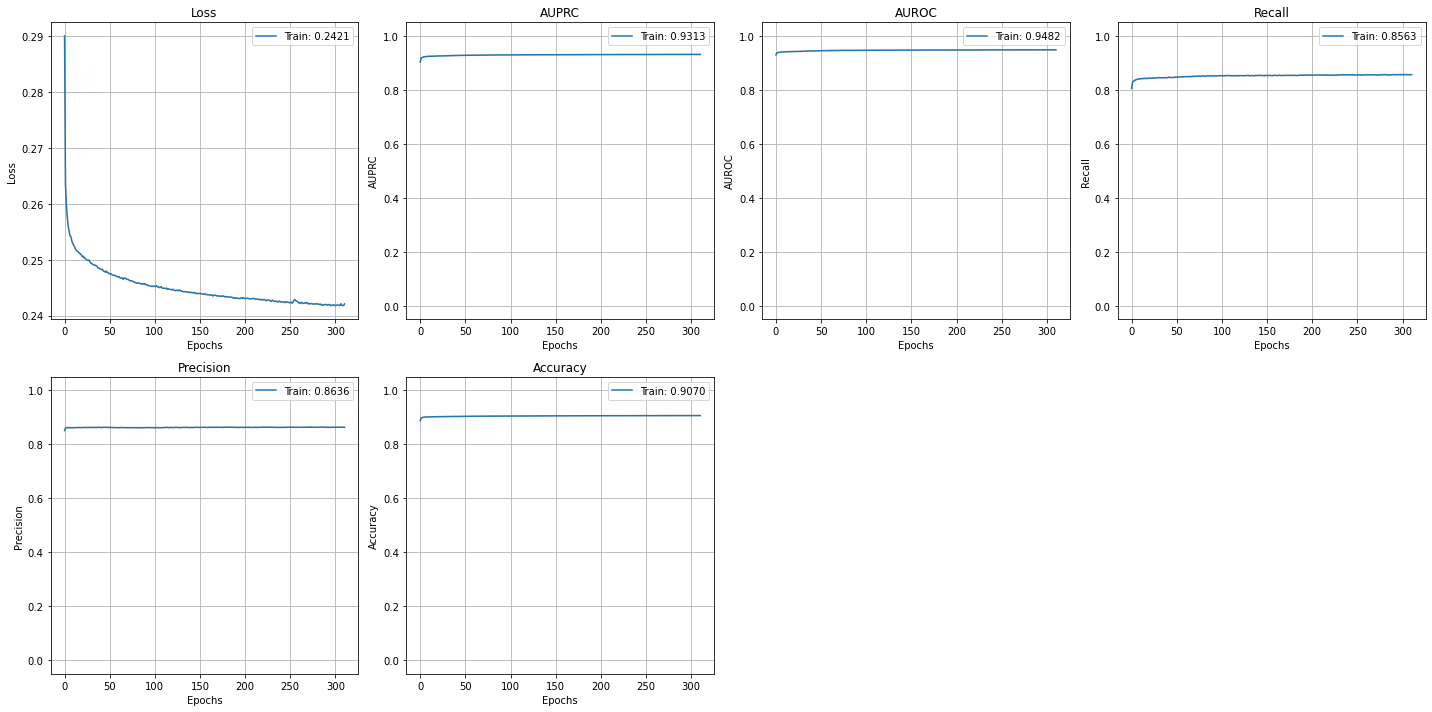

In [49]:
from plot_keras_history import plot_history
plot_history(history)

### Evaluate all edges from drug|compounds -> positive nodes (SARS-CoV-2, COVID-19, ARDS)

In [140]:
# these BP graph edges are the ones we want to evaluate
edges_to_eval = np.array(reduced_graph.get_bipartite_edge_names(
    removed_existing_edges=True,
    first_node_types_set=set(nodes_of_interest),
    second_nodes_set=set(positive_nodes.curie)
))

edge_transform = GraphTransformer(best_edge_method)
edge_transform.fit(reduced_graph_embedding)
edges_to_eval_emb = edge_transform.transform(edges_to_eval)

edges_to_eval_predict = mlp.predict(edges_to_eval_emb, batch_size=1048)

edges_to_eval_predict_sorted = pd.DataFrame({
    "pred": edges_to_eval_predict.flatten(),
    "subject": edges_to_eval[:,0],
    "object": edges_to_eval[:,1]
}).sort_values(by=["pred"], ascending=False)

edges_to_eval_predict_sorted[:50]

,pred,subject,object
226676,0.776691,CHEMBL.COMPOUND:CHEMBL343545,MESH:D045473
226672,0.776414,CHEMBL.COMPOUND:CHEMBL343545,NCBITaxon:227859
277655,0.774842,CHEBI:131933,MESH:D045169
404294,0.770889,CHEBI:60193,MESH:D045473
403265,0.769113,CHEBI:50858,MESH:D045473
347314,0.768964,CHEBI:77386,MESH:D045473
277654,0.768642,CHEBI:131933,NCBITaxon:2697049
362602,0.768295,CHEBI:138166,MESH:D045473
278889,0.767370,CHEBI:85511,MESH:D045473
367667,0.764049,CHEBI:50249,NCBITaxon:2697049


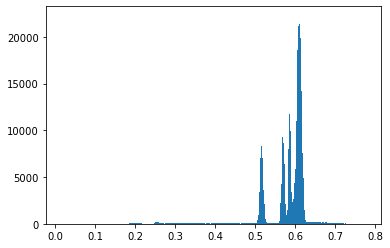

In [141]:
plt.hist(edges_to_eval_predict_sorted["pred"], bins=500);

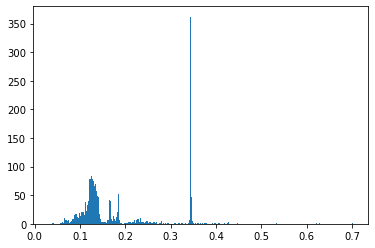

In [142]:
#  see what a BP graph with random edges looks like
from random import shuffle
nodes = reduced_graph.get_node_names()
shuffle(nodes)
random_nodes_left = nodes[0:500]
random_nodes_right = nodes[501:507]

random_edges_to_eval = np.array(reduced_graph.get_bipartite_edge_names(
    removed_existing_edges=True,
    first_nodes_set=set(random_nodes_left),
    second_nodes_set=set(random_nodes_right)
))

random_edge_transform = GraphTransformer(best_edge_method)
random_edge_transform.fit(reduced_graph_embedding)
random_edges_to_eval_emb = edge_transform.transform(random_edges_to_eval)

random_edges_to_eval_predict = mlp.predict(random_edges_to_eval_emb, batch_size=1048)

plt.hist(random_edges_to_eval_predict, bins=500);

#### Save model, history, and ranked drug list

In [44]:
# import pandas as pd
# import os
# edges_to_eval_predict_sorted = pd.read_csv(
#     os.path.join(mlp_link_pred_outdir, "mlp_link_pred_ranked_drug_compound_list.csv"),
#     index_col=0
# )

In [15]:
# add drug names and categories
nodes_info = pd.read_csv(nodes_file, sep="\t").filter(['id', 'name', 'category'])
edges_to_eval_predict_sorted = pd.merge(edges_to_eval_predict_sorted, nodes_info, how='left', left_on='subject', right_on='id').drop(labels=['id'], axis=1)
edges_to_eval_predict_sorted = edges_to_eval_predict_sorted[['pred', 'subject', 'name', 'category', 'object']]

/Users/jtr4v/PycharmProjects/kg_covid_19_drug_analyses/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,7,8,10,11,12,13,14,15,16,17,18,20,21,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,pred,subject,name_x,object,name_y
0,0.776691,CHEMBL.COMPOUND:CHEMBL343545,NaN,MESH:D045473,NaN
1,0.776414,CHEMBL.COMPOUND:CHEMBL343545,NaN,NCBITaxon:227859,NaN
2,0.774842,CHEBI:131933,(-)-DCA-CL(1-),MESH:D045169,(-)-DCA-CL(1-)
3,0.770889,CHEBI:60193,queuosine,MESH:D045473,queuosine
4,0.769113,CHEBI:50858,corticosteroid,MESH:D045473,corticosteroid
...,...,...,...,...,...
410955,0.018630,ttd.drug:D06WUE,"2,5-dichloro-N-p-tolylthiophene-3-sulfonamide",MESH:D045473,"2,5-dichloro-N-p-tolylthiophene-3-sulfonamide"
410956,0.018516,ttd.drug:D0M0ZX,6-ethyl-3-(2-ethylbutoxycarbonyl)-4-quinolone,MESH:D045473,6-ethyl-3-(2-ethylbutoxycarbonyl)-4-quinolone
410957,0.017998,ttd.drug:D02OZK,Obatoclax,MESH:D045473,Obatoclax
410958,0.017590,ttd.drug:D0I2RB,ONO-4641,MESH:D012128,ONO-4641


In [55]:
# add positive node names
edges_to_eval_predict_sorted = \
    pd.merge(edges_to_eval_predict_sorted, positive_nodes, how='left', left_on='object', right_on='curie').drop(labels=['curie'], axis=1)

In [148]:
mlp.save(
    os.path.join(mlp_link_pred_outdir, "mlp_link_pred.h5")
)
pd.DataFrame(history).to_csv(
    os.path.join(mlp_link_pred_outdir, "mlp_link_pred.history.csv")
)
edges_to_eval_predict_sorted.to_csv(
    os.path.join(mlp_link_pred_outdir, "mlp_link_pred_ranked_drug_compound_list.csv")
)

###  Upload the base_dl_dir (results, and cache stuff)

In [3]:
os.system(f"s3cmd put --recursive --acl-public --cf-invalidate {base_dl_dir} {s3_path}")

512